# Data Scientist Associate Case Study

## Company Background
EMO is a manufacturer of motorcycles. The company successfully launched its first electric moped in India in 2019. The product team knows how valuable owner reviews are in making improvements to their mopeds. 

Unfortunately they often get reviews from people who never owned the moped. They don’t want to consider this feedback, so would like to find a way to identify reviews from these people. They have obtained data from other mopeds, where they know if the reviewer owned the moped or not. They think this is equivalent to their own reviews.   


## Customer Question
Your manager has asked you to answer the following:
- Can you predict which reviews come from people who have never owned the moped before?  


## Dataset
The dataset contains reviews about other mopeds from a local website. The data you will use for this analysis can be accessed here: `"data/moped.csv"`

| Column Name      | Criteria                                                                                                                                                                    |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Used it for      | Character, the purpose of the electric moped for the user, one of “Commuting”, “Leisure”.                                                                                   |
| Owned for        | Character, duration of ownership of vehicle one of  “<= 6 months”, “> 6 months”, “Never Owned”.  Rows that indicate ownership should be combined into the category “Owned”. |
| Model name       | Character, the name of the electric moped.                                                                                                                                   |
| Visual Appeal    | Numeric, visual appeal rating (on a 5 point scale, replace missing values with 0).                                                                                           |
| Reliability      | Numeric, reliability rating (on a 5 point scale, replace missing values with 0).                                                                                             |
| Extra Feature    | Numeric, extra feature rating (on a 5 point scale, replace missing values with 0).                                                                                         |
| Comfort          | Numeric, comfort rating (on a 5 point scale, replace missing values with 0).                                                                                                 |
| Maintenance cost | Numeric, maintenance cost rating (on a 5 point scale, replace missing values with 0).                                                                                        |
| Value for money  | Numeric, value for money rating (on a 5 point scale, replace missing values with 0).                                                                                         |

# Data Scientist Associate Case Study Submission


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

## Data Validation

Our first task will be to import the csv file into a DataFrame and check the validity of the data and ensure that it complies with the formatting in the data dictionary. After we have ensured the integrity of out data we will convert it into formatting that is more easily manipulated for model fitting. 

In [3]:
# Data Validation
# Check all variables in the data against the criteria in the data dictionary above
moped_raw = pd.read_csv("data/moped.csv")
print(moped_raw.info()) #note that there are many null values. 
#furthermore, to enable model fitting column 1 should be converted to a boolean of owned or not, and model name can be made into a categorical.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Used it for       713 non-null    object 
 1   Owned for         713 non-null    object 
 2   Model Name        713 non-null    object 
 3   Visual Appeal     713 non-null    float64
 4   Reliability       713 non-null    float64
 5   Extra Features    183 non-null    float64
 6   Comfort           510 non-null    float64
 7   Maintenance cost  176 non-null    float64
 8   Value for Money   370 non-null    float64
dtypes: float64(6), object(3)
memory usage: 50.3+ KB
None


In [4]:
#lets look at all the values that appear in the DataFrame to see if there are any values that don't make sense (except for Model Name, which has no specified limitation on what it may be)
moped_raw[['Used it for', 'Owned for', 'Visual Appeal',
       'Reliability', 'Extra Features', 'Comfort', 'Maintenance cost',
       'Value for Money']].apply(pd.value_counts, dropna= False)

,Used it for,Owned for,Visual Appeal,Reliability,Extra Features,Comfort,Maintenance cost,Value for Money
1.0,NaN,NaN,90.0,176.0,60.0,74.0,31.0,85.0
2.0,NaN,NaN,38.0,53.0,24.0,38.0,18.0,25.0
3.0,NaN,NaN,106.0,91.0,15.0,64.0,15.0,35.0
4.0,NaN,NaN,192.0,157.0,37.0,150.0,75.0,118.0
5.0,NaN,NaN,287.0,236.0,47.0,184.0,37.0,107.0
NaN,NaN,NaN,NaN,NaN,530.0,203.0,537.0,343.0
<= 6 months,NaN,288.0,NaN,NaN,NaN,NaN,NaN,NaN
> 6 months,NaN,290.0,NaN,NaN,NaN,NaN,NaN,NaN
Commuting,553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leisure,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We do not have any unreasonable values, but all of the data is not in the format described by the data dictionary, as there are NaN values which need to be replaced with 0 in several columns. 
We will now replace the NaN values with 0 and check that there are no more NaN values in the DataFrame.

In [5]:
#now let's make sure the values in the DataFrame conform with the data dictionary specifications. 
#lets replace NaN with 0
moped_validated= moped_raw.fillna(value= 0)
#and check if it worked
moped_validated.isna().sum()

Used it for         0
Owned for           0
Model Name          0
Visual Appeal       0
Reliability         0
Extra Features      0
Comfort             0
Maintenance cost    0
Value for Money     0
dtype: int64

Now we will combine the 'Owned for' column values '> 6 months' and '<= 6 months' into 'Owned'

In [6]:
owned_dictionary = {'> 6 months' : 'Owned', '<= 6 months':'Owned'}
moped_validated['Owned for']= moped_validated['Owned for'].replace(owned_dictionary)
moped_validated['Owned for'].value_counts()

Owned          578
Never owned    135
Name: Owned for, dtype: int64

Now let's just make sure that the reviews are all for Mopeds and that the model names column has sensible values and we will have verified out dataset

In [7]:
moped_validated['Model Name'].value_counts()

Hero Electric Flash        94
Hero Electric Optima       75
Okinawa Praise             73
Revolt RV 400              44
PURE EV EPluto 7G          40
Hero Electric Photon       34
Tork Kratos                33
Ather 450X                 26
OLA S1 Pro                 25
Ampere Magnus EX           25
Ampere REO                 21
Benling Aura               19
OLA S1                     18
TVS iQube                  17
PURE EV ETrance Neo        16
Ampere Magnus Pro          16
Bajaj Chetak               13
Okinawa Ridge Plus         12
Okinawa i-Praise           11
Bounce Infinity E1         10
Ampere Zeal                 9
Hero Electric Optima CX     9
Hero Electric NYX           8
Techo Electra Raptor        8
Techo Electra Emerge        7
Okinawa R30                 6
Revolt RV 300               6
Okinawa Lite                6
Yo Drift                    5
Joy e-bike Wolf             5
Gemopai Ryder               5
e-bike Gen Nxt              3
Gemopai Astrid Lite         3
Hero Elect

Now that the Data is in the format as described by the data dictionary, let us convert the 'Used for' and 'Owned for' character columns into booleans to be more amenable to exploration and analysis, as well as model building.

In [8]:
moped= moped_validated.copy()
moped.rename(columns = {'Used it for':'Used for Commuting'}, inplace= True)
moped['Used for Commuting'] = (moped['Used for Commuting'] == 'Commuting')
moped.rename(columns= {'Owned for': 'Owned'}, inplace= True)
moped['Owned']=  (moped['Owned'] == 'Owned')
moped.head()

,Used for Commuting,Owned,Model Name,Visual Appeal,Reliability,Extra Features,Comfort,Maintenance cost,Value for Money
0,True,False,TVS iQube,3.0,4.0,0.0,4.0,0.0,1.0
1,False,True,TVS iQube,3.0,1.0,0.0,3.0,0.0,3.0
2,True,True,TVS iQube,4.0,4.0,0.0,5.0,0.0,2.0
3,True,True,TVS iQube,1.0,1.0,0.0,1.0,0.0,1.0
4,True,True,TVS iQube,3.0,4.0,0.0,3.0,0.0,2.0


## Exploratory Analysis

Before we can check for correlation and other summary statistics, we need to replace the 0 placeholder with NaN. 

In [10]:
moped_with_nan = moped.replace(0, np.nan)

Let's see the distribution of ratings

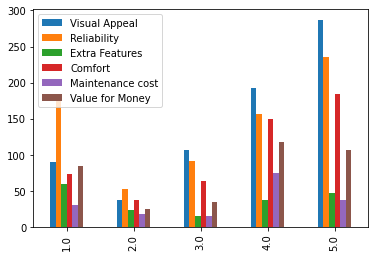

In [100]:
ratings_count= pd.DataFrame(moped_with_nan[['Visual Appeal',
       'Reliability', 'Extra Features', 'Comfort', 'Maintenance cost',
       'Value for Money']].apply(pd.value_counts))

ratings_count.plot(kind= 'bar')
plt.show()

now let's group by model and plot the mean values in a pairplot to get an idea if there is a correlation between the mean scores of a moped between variables

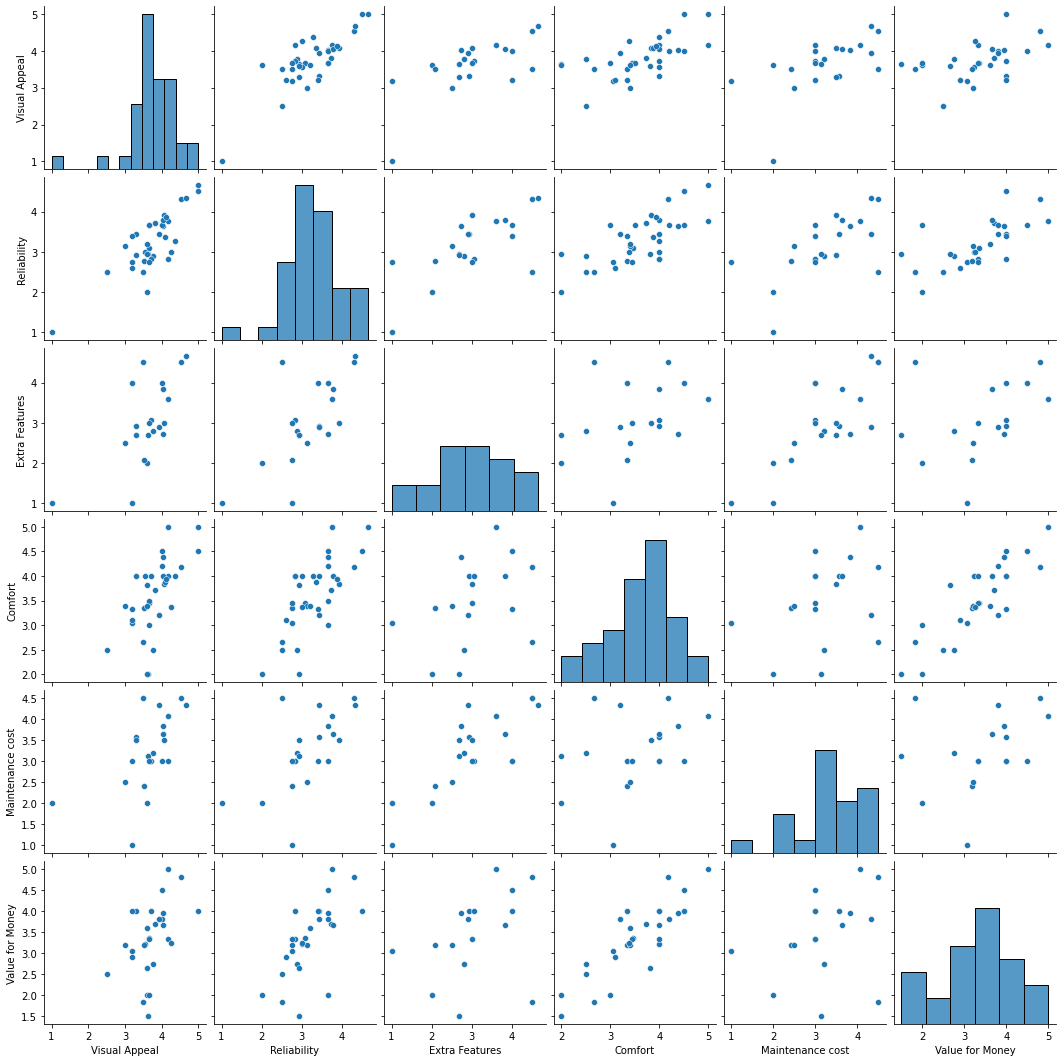

In [12]:
sns.pairplot(moped_with_nan[['Model Name','Visual Appeal',
       'Reliability', 'Extra Features', 'Comfort', 'Maintenance cost',
       'Value for Money']].groupby('Model Name').mean())
plt.show()

There does seem to be a significant correlation between a moped model's mean ratings in different categories. Categories that have fewer total responses seem to have more dispersion. Let's calculate the correlation matrix of ratings between categories on the total dataset.

In [13]:
correlation_index= moped_with_nan.corr()
moped_with_nan.corr()

,Used for Commuting,Owned,Visual Appeal,Reliability,Extra Features,Comfort,Maintenance cost,Value for Money
Used for Commuting,1.000000,0.203416,-0.111386,-0.182026,-0.063492,-0.209397,0.048504,-0.225386
Owned,0.203416,1.000000,-0.177128,-0.247763,-0.284534,-0.200778,-0.145776,-0.220279
Visual Appeal,-0.111386,-0.177128,1.000000,0.776160,0.747856,0.791839,0.617862,0.739694
Reliability,-0.182026,-0.247763,0.776160,1.000000,0.823643,0.811170,0.708368,0.824050
Extra Features,-0.063492,-0.284534,0.747856,0.823643,1.000000,NaN,0.623091,NaN
Comfort,-0.209397,-0.200778,0.791839,0.811170,NaN,1.000000,NaN,0.779055
Maintenance cost,0.048504,-0.145776,0.617862,0.708368,0.623091,NaN,1.000000,NaN
Value for Money,-0.225386,-0.220279,0.739694,0.824050,NaN,0.779055,NaN,1.000000


<AxesSubplot:>

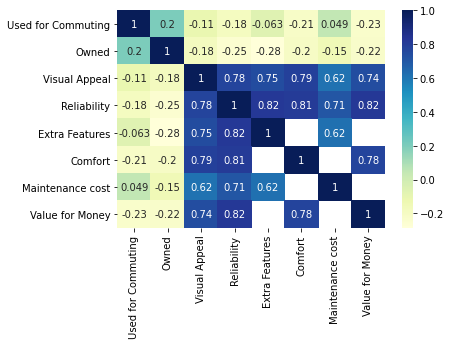

In [14]:
sns.heatmap(correlation_index, annot= True, cmap="YlGnBu")

We see that in the categories of 'Extra Features', 'Comfort', 'Maintenance cost', and 'Value for Money' the reviews do not overlap in all categories, meaning that respondants to Extra Features did not respond to 'Comfort' or 'Value for Money', only 'Maintenance cost'. "Comfort" respondents answered to 'Value for money' but not the other two. Possibly the rewiew questionaires only contained one of those two pairs. 

Visual Appeal, Reliability, Extra Features, Comfort, Maintenance cost, and Value for Money are all positively correlated with each other. This makes sense, as users who like a product tend to rate the product higher across all metrics. 
This can help us impute the data for the missing columns. Since we know that mopeds rarely recived diverging ratings accross columns, we can use the mean rating for the missing columns. 
lets confirm this by checking the mean rating by model. If they bunch together at the low and high ends and dip in the middle, it will confirm our analysis.


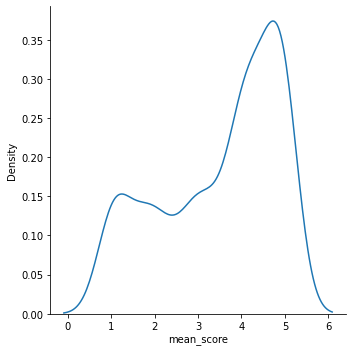

In [115]:
#lets make an average score of a mopeds 4 rating categories
numerical_ratings= ['Visual Appeal',
       'Reliability', 'Extra Features', 'Comfort', 'Maintenance cost',
       'Value for Money']
moped_with_nan['mean_score'] = moped_with_nan[numerical_ratings].mean(axis= 1).round(1)
sns.displot(data= moped_with_nan, x= 'mean_score', kind= 'kde')

it would seem that ratings tend to bunch together. The majority of mopeds do well across the metrcis averaging 4/5 while a minority do very poorly, averaging 1/2. Fewer fall in the middle and recieve a 3. 

--Explanitory Analysis part 2--

Now that we have analysed the relationship between the various numeric metrics and seen how they strongly correlate with each other, and that the ratings tend to bunch at the ends of the spectrum, lets see what impact Ownership and Commuting have on the data. 

In [16]:
#lets check the mean values by ownership

moped_by_ownership= moped_with_nan.drop(columns= 'Model Name').groupby('Owned').mean()
print ('mean ratings by ownership: \n', moped_by_ownership)



mean ratings by ownership: 
        Used for Commuting  Visual Appeal  Reliability  Extra Features  \
Owned                                                                   
False            0.600000       4.266667     4.125926        4.125000   
True             0.816609       3.652249     3.124567        2.748428   

        Comfort  Maintenance cost  Value for Money  mean_score  
Owned                                                           
False  4.194444          3.913043           4.2200    4.174815  
True   3.504975          3.313725           3.2375    3.347751  


Reviewers who do not own the mopeds on average rate them about 20% higher than those who own the moped being reviewed. <br>
let's plot the mean scores in each category grouped by ownership, and plot a regression plot of the relationship between ownership and the mean_score across all categories, and observe the negative correlation. 

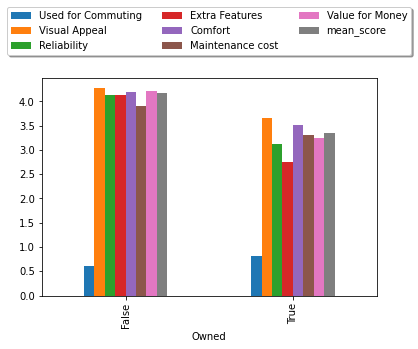

In [17]:
moped_by_ownership.plot(kind= 'bar')
plt.legend(loc= 'upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3, fancybox=True, shadow=True)
plt.show()

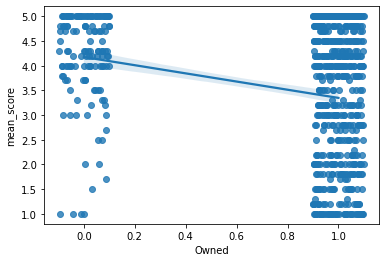

In [124]:
sns.regplot(data= moped_with_nan, y="mean_score", x="Owned", x_jitter= .1)
plt.show()

Let's see if there is a similar relationship between Commuters and mean_score

In [18]:
moped_by_commuting= moped_with_nan.drop(columns= 'Model Name').groupby('Used for Commuting').mean()
print(moped_by_commuting)


                       Owned  Visual Appeal  Reliability  Extra Features  \
Used for Commuting                                                         
False               0.662500       4.050000     3.850000        3.128205   
True                0.853526       3.687161     3.159132        2.875000   

                     Comfort  Maintenance cost  Value for Money  mean_score  
Used for Commuting                                                           
False               4.186441          3.257143         4.069444    3.937500  
True                3.489796          3.425532         3.201342    3.379024  


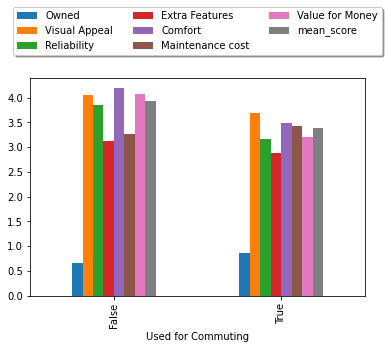

In [19]:
moped_by_commuting.plot(kind= 'bar')
plt.legend(loc= 'upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3, fancybox=True, shadow=True)
plt.show()

Commuters on average also give lower ratings than non-commuters, but the effect is far less pronounced than ownership.  

Let's plot histograms for the mean_score by ownership and use for commuting, to see which makes the most powerful impact on the distribution of mean score. 

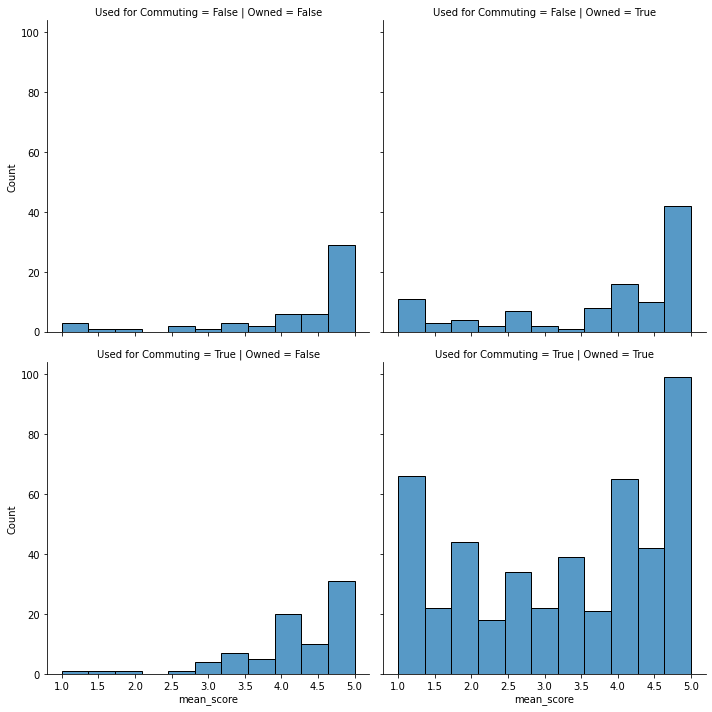

In [20]:
sns.displot(moped_with_nan, x="mean_score", col="Owned", row="Used for Commuting")

Clearly ownership determines the variability of mean score more than commuting. But Commuters who own their mopeds display a much greater range in their ratings, and are much more likely to give a moped a low rating. This subgroup is the source of nearly all of our negative reviews. 

## Exploratory Analysis- conclusion

From our exploratory analysis we've noted some important features of the data. From our correlation matrix heatmap we've seen that some of the questions are linked- some reviewers only received certain pairs of questions, and that overall there is a strong relationship between ratings given by a user accross categories. <br>
In light of the strong correlation between rating categories, and the presence of significant amounts of null values in some rating categories, we created a mean_score column with the mean of all available scores from each row in order to get a better overall picture of the relationship of metrics to a moped's reviews. From our regression plot of Ownership and mean_score we saw that ownership is negatively associated with mean_score. Our distribution plot showed that owners who also use their moped's for commuting are the main source of negative reviews, while in all other categories the vast majority of users give positive ratings.

## Model Fitting

Because our primary objective is to predict if reviews are coming from people who have never owned the moped, our primary concern is eliminating non-owners, even at the expense of some false positives. While we would prefer not to discard too many owner reviews, we are going to prioritize not wasting time on non-owner reviews. Which means that the primary metric we'd like to use to evaluate our models is going to be their recall/sensitivity. 

In order to facilitate modeling, lets remove the 12 rows with 4 missing values, and drop the model name. <br>
Then we'll try and address the missing values with three approaches: <br>
* First, we'll make a dataset with just the complete columns. <br>
* Then, since we saw that ratings accross metrics tend to bunch together, let's impute null values with the mean score of the row. <br>
* We will also create an alternate imputation where we replace the missing values with 0. <br>
* We will apply our models to both data sets in order to see which is more suitable. <br>
Finally we'll scale the values, so that the boolean value of Used for Commuting isn't underweighted by our models. 

In [22]:
moped_useful_rows= moped_with_nan.copy().drop(columns= ['Model Name'])
moped_useful_rows['Not_Owned']= ~moped_useful_rows['Owned']
moped_useful_rows= moped_useful_rows.drop(columns=['Owned'])
moped_useful_rows= moped_useful_rows[moped_useful_rows.isna().sum(axis= 1) != 4]
moped_imp_0= moped_useful_rows.fillna(value= 0)
y_moped_imp_0= moped_imp_0['Not_Owned']
X_moped_imp_0= moped_imp_0.drop(columns=['Not_Owned'])
zero_scaler= StandardScaler()
Xscaled_moped_imp_0= zero_scaler.fit_transform(X_moped_imp_0)
X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test = train_test_split(Xscaled_moped_imp_0, y_moped_imp_0, test_size=0.3, random_state=42, stratify= y_moped_imp_0)

moped_imp_row_mean= moped_useful_rows.apply(lambda row: row.fillna(row[numerical_ratings].mean()), axis=1)
y_moped_imp_row_mean= moped_imp_row_mean['Not_Owned']
X_moped_imp_row_mean= moped_imp_row_mean.drop(columns=['Not_Owned'])
mean_scaler= StandardScaler()
Xscaled_moped_imp_row_mean = mean_scaler.fit_transform(X_moped_imp_row_mean)
X_imp_mean_train, X_imp_mean_test, y_imp_mea_train, y_imp_mean_test = train_test_split(Xscaled_moped_imp_row_mean, y_moped_imp_row_mean, test_size=0.3, random_state=42, stratify= y_moped_imp_row_mean)

moped_dropna= moped_useful_rows.dropna(axis= 1).drop(columns=['mean_score'])
y_moped_dropna= moped_dropna['Not_Owned']
X_moped_dropna= moped_dropna.drop(columns=['Not_Owned'])
dropna_scaler= StandardScaler()
Xscaled_moped_dropna = dropna_scaler.fit_transform(X_moped_dropna)
X_dropna_train, X_dropna_test, y_dropna_train, y_dropna_test = train_test_split(X_moped_dropna, y_moped_dropna, test_size=0.3, random_state=42, stratify= y_moped_dropna)


In [23]:
#helper function
def modeler(model, X_train, X_test,y_train, y_test):
    """a helper function that takes a model to train and the training and test data. Returns the score, confusion matrix and classification report"""
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    print(model.score(X_test, y_test))
    confusion_matrix_of_model= confusion_matrix(y_test, y_pred)
    print('\n confusion matrix : {}'.format(confusion_matrix_of_model))
    target_names = ['Owners', 'Non-Owners']
    print(classification_report(y_test, y_pred, target_names=target_names))
    sns.heatmap(pd.DataFrame(confusion_matrix_of_model), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Since this is a binary classification problem, we'll start with logistic regression as our baseline model. 

First, we'll see if using just the complete columns is effective. 

0.8104265402843602

 confusion matrix : [[171   0]
 [ 40   0]]
              precision    recall  f1-score   support

      Owners       0.81      1.00      0.90       171
  Non-Owners       0.00      0.00      0.00        40

    accuracy                           0.81       211
   macro avg       0.41      0.50      0.45       211
weighted avg       0.66      0.81      0.73       211



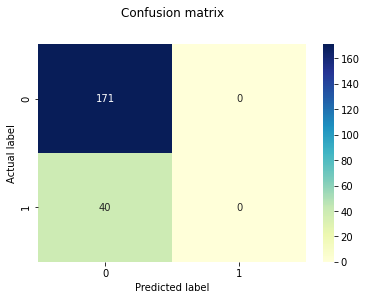

In [25]:
lrD= LogisticRegression()
modeler(lrD, X_dropna_train, X_dropna_test, y_dropna_train, y_dropna_test)

Clearly using just the columns with no null values doesn't provide sufficient data for our model to work with, the model didn't even make a single prediction of non-ownership. 

0.7630331753554502

 confusion matrix : [[155  16]
 [ 34   6]]
              precision    recall  f1-score   support

      Owners       0.82      0.91      0.86       171
  Non-Owners       0.27      0.15      0.19        40

    accuracy                           0.76       211
   macro avg       0.55      0.53      0.53       211
weighted avg       0.72      0.76      0.73       211



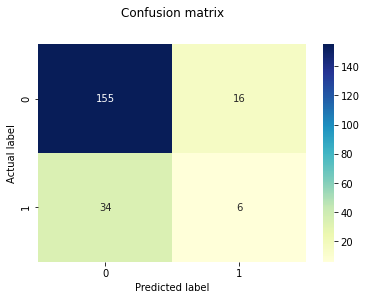

In [26]:
lr0= LogisticRegression(random_state= 42)

modeler(lr0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

0.8104265402843602

 confusion matrix : [[171   0]
 [ 40   0]]
              precision    recall  f1-score   support

      Owners       0.81      1.00      0.90       171
  Non-Owners       0.00      0.00      0.00        40

    accuracy                           0.81       211
   macro avg       0.41      0.50      0.45       211
weighted avg       0.66      0.81      0.73       211



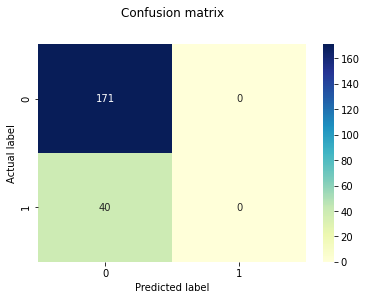

In [27]:
lrM= LogisticRegression(random_state= 42)
modeler(lrM, X_imp_mean_train, X_imp_mean_test, y_imp_mea_train, y_imp_mean_test)

Our baseline Logistic regression model using 0 to fill Null entries caught 15% of non-owner reviews. while other imputation methods faired poorly. 
It would seem that using only the collumns with no null values doesn't give our model enough data to work with.
let's continue to use imputed 0 values for null entries, and use this linear classification model as our baseline. 
now let's try another model.

0.7772511848341233

 confusion matrix : [[159  12]
 [ 35   5]]
              precision    recall  f1-score   support

      Owners       0.82      0.93      0.87       171
  Non-Owners       0.29      0.12      0.18        40

    accuracy                           0.78       211
   macro avg       0.56      0.53      0.52       211
weighted avg       0.72      0.78      0.74       211



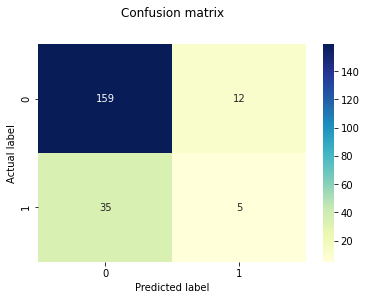

In [28]:
svc0= SVC(random_state= 42)

modeler(svc0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

using a Support Vector Machine model faired worse than our linear model. So let's stick with the linear model as our baseline.

0.8104265402843602

 confusion matrix : [[171   0]
 [ 40   0]]
              precision    recall  f1-score   support

      Owners       0.81      1.00      0.90       171
  Non-Owners       0.00      0.00      0.00        40

    accuracy                           0.81       211
   macro avg       0.41      0.50      0.45       211
weighted avg       0.66      0.81      0.73       211



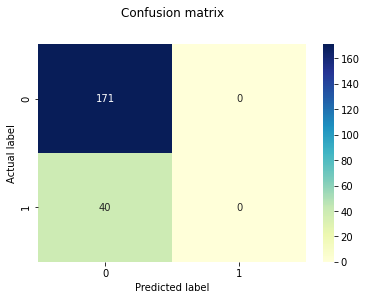

In [130]:
knnD= KNeighborsClassifier(n_neighbors= 5)
modeler(lrD, X_dropna_train, X_dropna_test, y_dropna_train, y_dropna_test)

Once again, using just the complete columns didn't provide our model enough data to even attempt predictions. From here on we'll stick to using the imputed row mean and 0 as a fill method. 

0.7725118483412322

 confusion matrix : [[154  17]
 [ 31   9]]
              precision    recall  f1-score   support

      Owners       0.83      0.90      0.87       171
  Non-Owners       0.35      0.23      0.27        40

    accuracy                           0.77       211
   macro avg       0.59      0.56      0.57       211
weighted avg       0.74      0.77      0.75       211



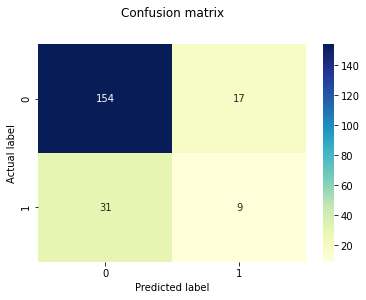

In [29]:
knn0= KNeighborsClassifier(n_neighbors= 5)
modeler(knn0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

0.7819905213270142

 confusion matrix : [[163   8]
 [ 38   2]]
              precision    recall  f1-score   support

      Owners       0.81      0.95      0.88       171
  Non-Owners       0.20      0.05      0.08        40

    accuracy                           0.78       211
   macro avg       0.51      0.50      0.48       211
weighted avg       0.70      0.78      0.73       211



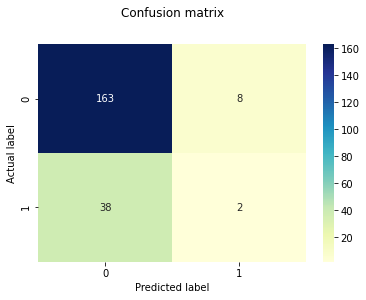

In [30]:
knnM= KNeighborsClassifier()
modeler(knnM, X_imp_mean_train, X_imp_mean_test, y_imp_mea_train, y_imp_mean_test)

A KNN classifier using imputed 0 values has a recall of around 20%. So far our best model, but because we are operating with several columns, the high dimensionality makes KNN unlikely to be our best option. Let's see if we can imporove. 
(Once again, using the imputed row mean faired worse)

0.7725118483412322

 confusion matrix : [[149  22]
 [ 26  14]]
              precision    recall  f1-score   support

      Owners       0.85      0.87      0.86       171
  Non-Owners       0.39      0.35      0.37        40

    accuracy                           0.77       211
   macro avg       0.62      0.61      0.61       211
weighted avg       0.76      0.77      0.77       211



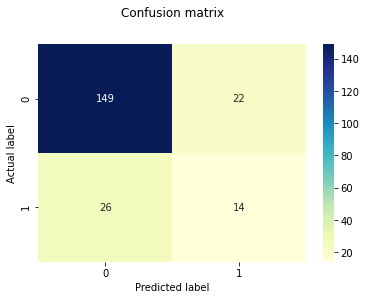

In [31]:
dt0= DecisionTreeClassifier(random_state= 42)
modeler(dt0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

0.7582938388625592

 confusion matrix : [[145  26]
 [ 25  15]]
              precision    recall  f1-score   support

      Owners       0.85      0.85      0.85       171
  Non-Owners       0.37      0.38      0.37        40

    accuracy                           0.76       211
   macro avg       0.61      0.61      0.61       211
weighted avg       0.76      0.76      0.76       211



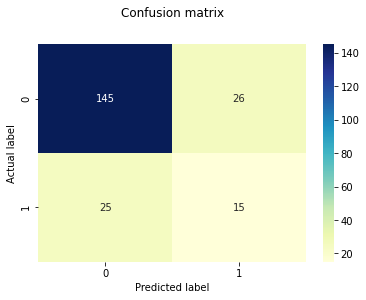

In [32]:
dtM= DecisionTreeClassifier(random_state= 42)
modeler(dtM, X_imp_mean_train, X_imp_mean_test, y_imp_mea_train, y_imp_mean_test)

with a decision tree model we're able to catch about 35% of non-owner respondents (thought our overall accuracy isn't improving)

let's try a gridsearch, and see if that improves our decision tree

{'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 0.03}
0.3911111111111111
0.7440758293838863

 confusion matrix : [[146  25]
 [ 29  11]]
              precision    recall  f1-score   support

      Owners       0.83      0.85      0.84       171
  Non-Owners       0.31      0.28      0.29        40

    accuracy                           0.74       211
   macro avg       0.57      0.56      0.57       211
weighted avg       0.73      0.74      0.74       211



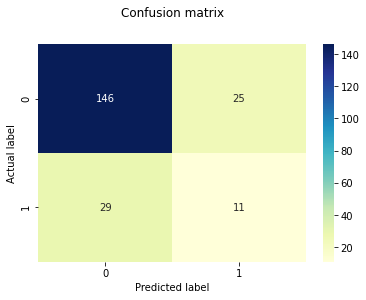

In [33]:
#gridsearch with decision tree
dt0_gs= DecisionTreeClassifier(random_state= 42)
params_dt= {'max_depth': [3,4,5,6,7,8,9], 'min_samples_leaf': [0.03, 0.04, .06, .08], 'max_features':[0.1, 0.2, 0.4, .6, .8]}
grid_dt0= GridSearchCV(estimator= dt0_gs, param_grid= params_dt, scoring= 'recall', cv= 10, n_jobs= -1 )
grid_dt0.fit(X_imp0_train,y_imp0_train )
best_params= grid_dt0.best_params_
print(best_params)
print(grid_dt0.best_score_)

best_model_grid_dt0= grid_dt0.best_estimator_
modeler(best_model_grid_dt0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

Our original decision tree still identifies more non-owner reviews. <br>
Let's see if various boosting or ensemble methods can improve upon our model's performance. 

0.7772511848341233

 confusion matrix : [[152  19]
 [ 28  12]]
              precision    recall  f1-score   support

      Owners       0.84      0.89      0.87       171
  Non-Owners       0.39      0.30      0.34        40

    accuracy                           0.78       211
   macro avg       0.62      0.59      0.60       211
weighted avg       0.76      0.78      0.77       211



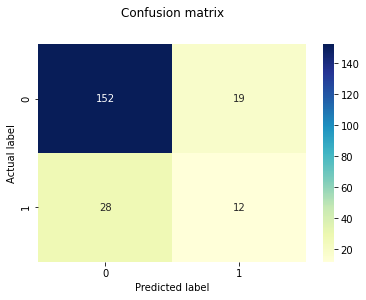

In [34]:
dt_stump0= DecisionTreeClassifier(max_depth= 3, random_state= 42)
adb_clf0= AdaBoostClassifier(base_estimator= dt_stump0, n_estimators= 100)
modeler(adb_clf0,  X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

30% with AdaBoost

0.7914691943127962

 confusion matrix : [[154  17]
 [ 27  13]]
              precision    recall  f1-score   support

      Owners       0.85      0.90      0.88       171
  Non-Owners       0.43      0.33      0.37        40

    accuracy                           0.79       211
   macro avg       0.64      0.61      0.62       211
weighted avg       0.77      0.79      0.78       211



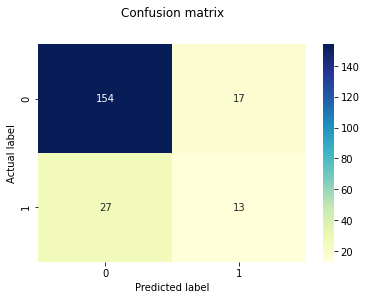

In [35]:
gbt0= GradientBoostingClassifier(n_estimators= 300, max_depth= 4, random_state= 42)
modeler(gbt0,X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)


33% with GradientBoosting

0.7819905213270142

 confusion matrix : [[155  16]
 [ 30  10]]
              precision    recall  f1-score   support

      Owners       0.84      0.91      0.87       171
  Non-Owners       0.38      0.25      0.30        40

    accuracy                           0.78       211
   macro avg       0.61      0.58      0.59       211
weighted avg       0.75      0.78      0.76       211



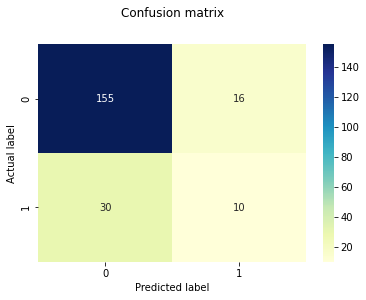

In [36]:
rf0= RandomForestClassifier(n_estimators= 400)
modeler(rf0, X_imp0_train, X_imp0_test, y_imp0_train, y_imp0_test)

only 25% with random forest

## Model Evaluation

The best model is the DecisionTreeClassifier, using 0 to replace null values in the dataset. 
with an overall accuracy of 0.7725118483412322 the model was within several percentage points of the best overall model accuracy of 81%. However, since those model's acheived that by simply predicting all reviewers as owners which is true of 80% of the dataset, and therefore was correct 80% of the time.  <br>
Our task however is to eliminate non-owener reviewers in order to focus on reviews by actual owners. As such the most important factor for us is recall balanced by accuracy (if our model returned a prediction of non-owner for everyone it would also be useless). We want to discard the maximum number of non-owner reviews without seriously damaging our overall accuracy. Our decision tree model acheived the highest recall of 35%. Using the row's mean score to replace null values in a decision tree classifier worked well too, but was only 75% accurate. 
Some of the ensemble methods worked as well, but are far more computationally demanding, and didn't provide any additional benefit. 

Our Model winner: <br>
DecisionTreeClassifier, using 0 to replace null values in the dataset. <br>
accuracy: 0.7725118483412322 <br>
accurately predicted: 14/40 non-onwers. (recall = .35)

In [38]:
dtc_confusion_matrix= pd.DataFrame([[149 , 22],[ 26 , 14]], columns= ['predicted owners', 'predicted non-owners'], index=  ['actual owners', 'actual non-owners'])
print(dtc_confusion_matrix)

                   predicted owners  predicted non-owners
actual owners                   149                    22
actual non-owners                26                    14


With this model we can discard about 35% of non-owner reviews without unduly discarding too many real users' reviews. So while we cannot predict all non-owner reviews, we can significanlty reduce the time wasted on reviews by non-owners. <br>
Another factor to we should take into account from our exploratory data analysis is that almost all non-owner reviews are very strongly positive. Reviews that have something bad to say are disproportionally from owners of the moped. Paying particular attention to reviews that have something bad to say is a surefire way of focusing on feedback from actual owners. <br>
In conjunction with our machine learning model this can really help streamline the company's use of customer reviews to improve the product. 